# Classification benchmark: PLN-Tree

In [54]:
from plntree.models import PLNTreeConditional, PLNTree
from plntree.utils.classifiers import DenseClassifier, RNNClassifier
from plntree.utils.jupyter_functions import *
from plntree.data.utils import numpy_dataset_to_torch_dataloader
import torch
import torch.optim as optim

# Metagenomics dataset

## Dataset import

In [55]:
seed = 0
# Select the taxonomic precision
precision = 'f'
prefix = f'metagenomics_classification_taxaL{precision}_s{seed}'

seed_all(seed)

In [56]:
from plntree.data import metagenomics_loader

raw_abundances, metadata = metagenomics_loader.load_raw_data(directory='./plntree/data/metagenomics')

In [57]:
diseases = ['t2d', 'ibd_ulcerative_colitis', 'cirrhosis', 'ibd_crohn_disease', 'cancer', 'obesity', 'leaness']
raw_abundances, metadata = metagenomics_loader.filter_diseases(raw_abundances, metadata, diseases)

In [58]:
# Filter out some taxa
filtered_taxa = ['k__Archaea', 'k__Eukaryota']
# Select the rarefaction offset
rarefaction_offset = 12
# Select the prevalence threshold (-1 for none)
prevalence = 1 / np.exp(rarefaction_offset)

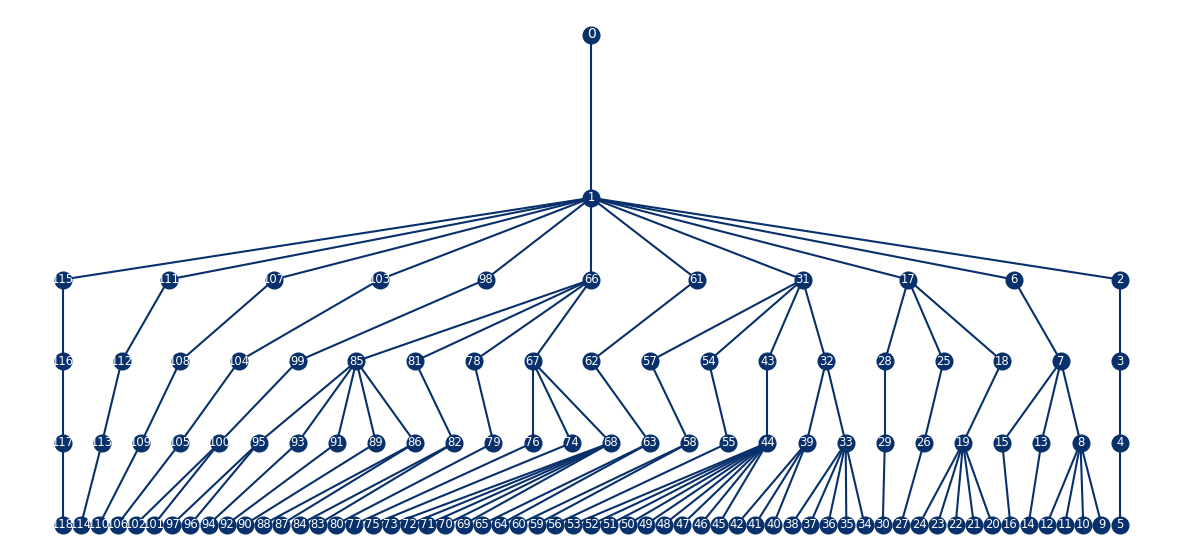

In [59]:
abundances = metagenomics_loader.raw_abundance_filter(raw_abundances, precision)
for taxon in filtered_taxa:
    abundances = metagenomics_loader.exclude_taxon(abundances, taxon)
if prevalence > 0:
    abundances = metagenomics_loader.prevalence_filter(abundances, threshold=prevalence)
abundances = metagenomics_loader.rarefy(abundances, rarefaction_offset, seed=seed)

taxonomy = metagenomics_loader.get_taxonomy(abundances)
taxonomy.plot(legend=False, title='')

In [60]:
from torch.utils.data import DataLoader, TensorDataset
# Select the offset layer
selected_layers = [2, -1]
K = list(taxonomy.getLayersWidth().values())[selected_layers[0]:]
X_base, patient_ids = metagenomics_loader.hierarchical_dataset(abundances, taxonomy, offset_layer=selected_layers[0])

# Select the batch size
batch_size = len(X_base)
seed_all(seed)
dataset = TensorDataset(X_base.to(dtype=torch.float64), X_base.to(dtype=torch.float64))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

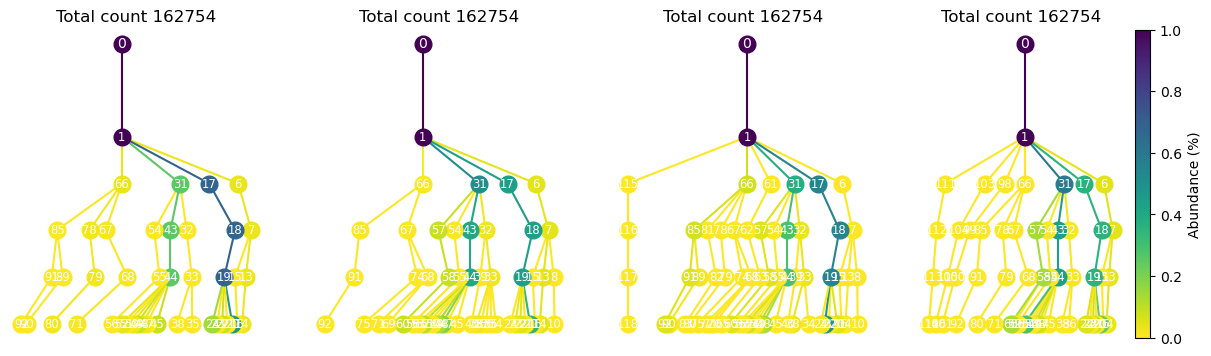

In [62]:
vizualize_samples(dataloader, taxonomy, selected_layers, autofill=True, seed=seed)
savefig('metagenomics_samples')

## Visualize the problem's difficulty with PCA

In [9]:
from sklearn.decomposition import PCA
import matplotlib.lines as mlines
import matplotlib

Y_base = metadata['disease']
def plot_pca(Y_base, X_base):
    fig, axs = plt.subplots(1, len(K), figsize=(15, 4))
    colors = [matplotlib.cm.get_cmap('viridis')((i+1)/len(np.unique(Y_base))) for i, name in enumerate(np.unique(Y_base))]
    for layer, K_l in enumerate(K):
        X_l = X_base[:, layer, :K_l]
        pca = PCA(n_components=2, random_state=seed).fit(X_l)
        X_l_pca = pca.transform(X_l)
        for k, c in enumerate(np.unique(Y_base)):
            indexes = np.where(Y_base == c)
            axs[layer].set_title(f'$\ell = {layer + selected_layers[0]}$')
            axs[layer].plot(X_l_pca[indexes, 0], X_l_pca[indexes, 1], marker='.', linestyle='', color=colors[k], alpha=0.5)
            axs[layer].set_xlabel(f'axis 1 ({np.round(pca.explained_variance_ratio_[0] * 100, 1)}%)')
            axs[layer].set_ylabel(f'axis 2 ({np.round(pca.explained_variance_ratio_[1] * 100, 1)}%)')
    legend_handles = [
            mlines.Line2D([], [], marker='o', linestyle='', color=color, alpha=0.9, label=group)
            for color, group in zip(colors, np.unique(Y_base))
        ]
    legend = plt.legend(handles=legend_handles, fontsize="12", loc='lower center', bbox_to_anchor=(-1.65, -0.32), ncols=len(colors))
    plt.subplots_adjust(wspace=0.4)
plot_pca(Y_base, X_base / X_base[:, 0].sum(dim=-1, keepdims=True).unsqueeze(-1))
savefig(f'{prefix}_PCA_all_diseases')

In [10]:
n_classes = len(np.unique(Y_base))
n_classes

In [11]:
print(np.unique(Y_base, return_counts=True))

## Preprocessing using PLN models

In [12]:
pln_layers = learn_pln(X_base, K, seed=seed)

In [13]:
def get_plntree_params_and_suffix(n_latent_layers, variational_approx, variational_approx_params):
    params = {
        'tree':taxonomy,
        'selected_layers':selected_layers,
        'diagonal_model':False,
        'variational_approx':variational_approx,
        'positive_fun':'softplus',
        'offset_method':'constant',
        'variational_approx_params':variational_approx_params,
        'n_latent_layers':n_latent_layers,
        'diag_smoothing_factor':1e-4
    }
    placeholder = variational_approx_params
    if variational_approx == 'mean_field':
        placeholder = variational_approx_params['n_variational_layers']
    suffix = f'latentlayers-{n_latent_layers}_varlayers-{placeholder}'
    return params, suffix

def learn_plntree_mean_field(params):
    estimator = PLNTree(**params, seed=seed)

    optimizer = optim.Adam(
        estimator.parameters(),
        lr=1e-3,
    )
    n_epoch = 30_000
    return estimator.fit(optimizer, dataloader, n_epoch=n_epoch, verbose=100, max_grad_norm=10.)

n_latent_layers = 1
n_variational_layers = 3
preprocessing = 'proportion'
print('Latents size', n_latent_layers)
print('Variational size', n_variational_layers)
variational_approx_params = {
    'n_variational_layers':n_variational_layers,
    'preprocessing': [preprocessing]
}
params, suffix = get_plntree_params_and_suffix(n_latent_layers, 'mean_field', variational_approx_params)
try:
    meanfield, meanfield_losses = load_pkl(prefix, f'mean_field_{preprocessing}_{suffix}')
except:
    meanfield, meanfield_losses = learn_plntree_mean_field(params)
    save_pkl((meanfield, meanfield_losses), prefix, f'mean_field_{preprocessing}_{suffix}')

In [14]:
fig, axs = plt.subplots()
axs.plot(meanfield_losses)
axs.set_yscale('log')

In [15]:
preprocessing = 'proportion'
def learn_plntree(n_latent_layers, variational_approx, variational_approx_params):
    estimator = PLNTree(
        tree=taxonomy,
        selected_layers=selected_layers,
        diag_smoothing_factor=1e-4,
        positive_fun='softplus',
        offset_method='constant',
        identifiable=True,
        variational_approx=variational_approx,
        variational_approx_params=variational_approx_params,
        n_latent_layers=n_latent_layers,
        seed=seed
    )
    optimizer = optim.Adam(
        estimator.parameters(),
        lr=1e-3,
    )
    estimator.to(dtype=torch.float64)
    n_epoch = 30_000
    return estimator.fit(optimizer, dataloader, n_epoch=n_epoch, verbose=100, max_grad_norm=5.)

def embedder_params(embedder_type='GRU', embedding_size=16, n_embedding_layers=2, n_embedding_neurons=32, n_after_layers=2):
    params = {
        'embedder_type': embedder_type,
        'embedding_size': embedding_size,
        'n_embedding_layers': n_embedding_layers,
        'n_embedding_neurons': n_embedding_neurons,
        'n_after_layers': n_after_layers,
        'preprocessing': ['proportion']
    }
    name = f'Emb{embedder_type}-{n_embedding_layers}x{n_embedding_neurons}to{embedding_size}-{n_after_layers}'
    return name, params

n_latent_layers = 1
emb_name, variational_approx_params = embedder_params(
    embedding_size=32,
    n_embedding_layers=2,
    n_embedding_neurons=64,
    n_after_layers=2
)
try:
    backward, backward_losses = load_pkl(prefix, f'residual_backward_{preprocessing}_{n_latent_layers}-{emb_name}')
except:
    print('Learning PLN-Tree (residual backward)')
    print(variational_approx_params)
    backward, backward_losses = learn_plntree(n_latent_layers, 'residual_backward', variational_approx_params)
    save_pkl((backward, backward_losses), prefix, f'residual_backward_{preprocessing}_{n_latent_layers}-{emb_name}')

In [16]:
fig, axs = plt.subplots()
axs.plot(backward_losses)
axs.set_yscale('log')

In [17]:
Z_meanfield, _ = meanfield.encode(X_base, seed=42)
Z_backward, _ = backward.encode(X_base, seed=42)

In [18]:
Z_pln_enc = generate_pln_data(pln_layers, 1, K, selected_layers, X_base, taxonomy, seed=seed)[-2]

In [19]:
from sklearn.decomposition import PCA
import matplotlib.lines as mlines
import matplotlib

Y_base = metadata['disease'].copy()
prefix_labels = 'all_diseases-'
plot_pca(Y_base, Z_backward.detach())

In [20]:
from sklearn.decomposition import PCA
import matplotlib.lines as mlines
import matplotlib

Y_base = metadata['disease'].copy()
prefix_labels = 'all_diseases-'
plot_pca(Y_base, torch.log(backward.latent_tree_allocation(Z_backward)).detach())
savefig(f'{prefix}_PCA_all_diseases_latent_allocation')

In [32]:
from sklearn.decomposition import PCA
import matplotlib.lines as mlines
import matplotlib

scenario = 't2d'

if scenario == 'ibd':
    filtered_labels = ['ibd_crohn_disease', 'ibd_ulcerative_colitis']
elif scenario == 'cirrhosis':
    filtered_labels = ['cirrhosis']
elif scenario == 'obesity':
    filtered_labels = ['obesity']
elif scenario == 'colorectal':
    filtered_labels = ['cancer']
elif scenario == 'leaness':
    filtered_labels = ['leaness']
elif scenario == 't2d':
    filtered_labels = ['t2d']
elif scenario == 't2d_obe':
    filtered_labels = ['t2d', 'obesity']
elif scenario == 'cirr_col':
    filtered_labels = ['cirrhosis', 'colorectal']
prefix_labels = ''
for label in filtered_labels:
    prefix_labels += f'-{label}'
Y_base = metadata['disease'].copy()
for i in range(len(Y_base)):
    if Y_base[i] not in filtered_labels:
        Y_base[i] = 'Others'
    else:
        Y_base[i] = 'Targets'

plot_pca(Y_base, torch.log(backward.latent_tree_allocation(Z_backward)).detach())

In [33]:
n_classes = len(np.unique(Y_base))
n_classes

In [34]:
print(np.unique(Y_base, return_counts=True))

## Benchmark models

In [35]:
from sklearn.model_selection import StratifiedShuffleSplit

def train_test(X, y, train_indexes, test_indexes):
    X_train, y_train = X[train_indexes], y[train_indexes]
    X_test, y_test = X[test_indexes], y[test_indexes]
    return X_train, y_train, X_test, y_test

def bootstrap_train(X, y, model, params, n_repeats=10, train_size=0.8, seed=None, verbose=False):
    seed_all(seed)
    models = []
    indexes = np.arange(0, len(X))
    for i, (train_indexes, test_indexes) in enumerate(StratifiedShuffleSplit(n_splits=n_repeats, train_size=train_size).split(X, y)):
        X_train, y_train, X_test, y_test = train_test(X, y, train_indexes, test_indexes)
        assert((np.unique(y_train) == np.unique(y_test)).all())
        if verbose:
            print(f'Fitting Fold {i}...')
        benchmark = model(**params).fit(X_train, y_train)
        models.append((benchmark, train_indexes, test_indexes))
    return models

In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, balanced_accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc, average_precision_score, RocCurveDisplay
import pandas as pd
from scipy import interp
from scipy.stats import mstats
import math

def performances(X, y, benchmarks, predict_args=None):
    if predict_args is None:
        predict_args = {}
    metrics = {
        'accuracy':accuracy_score,
        'precision':lambda y_test, y_pred: precision_score(y_test, y_pred, average='weighted'),
        'recall':lambda y_test, y_pred: recall_score(y_test, y_pred, average='weighted'),
        'F1':lambda y_test, y_pred: f1_score(y_test, y_pred, average='weighted'),
        'balanced accuracy':balanced_accuracy_score,
    }
    results = {f'{key}':[] for key in metrics}
    conf_matrices = []
    auc_args = []
    pr_args = []
    auc_values = []
    auc_pr_values = []
    pr_values = []
    for model, train_indexes, test_indexes in benchmarks:
        X_train, y_train, X_test, y_test = train_test(X, y, train_indexes, test_indexes)
        y_proba = model.predict_proba(X_test, **predict_args)
        if len(predict_args) == 0:
            y_pred = model.predict(X_test)
        else:
            y_pred = model.predict(X_test, predict_args)
        for metric, metric_fun in metrics.items():
            results[metric].append(metric_fun(y_test, y_pred))
            
        conf_matrices.append(confusion_matrix(y_test, y_pred))
        
        if len(np.unique(y)) == 2:
            fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, 1])
            base_fpr = np.linspace(0, 1, 101)
            tpr_interp = interp(base_fpr, fpr, tpr)
            tpr_interp[0] = 0.0
            auc_args.append(tpr_interp)
            auc_values.append(auc(fpr, tpr))
            
            precisions, recalls, pr_thresh = precision_recall_curve(y_test, y_proba[:, 1])
            base_recalls = np.linspace(0, 1, 101)
            pre_interp = interp(base_recalls, np.flip(recalls), np.flip(precisions))
            pre_interp[0] = np.flip(precisions)[0]
            pr_args.append(pre_interp)
            auc_pr_values.append(auc(recalls, precisions))
            pr_values.append(average_precision_score(y_test, y_proba[:, 1]))
    if len(auc_values) > 0:
        results['ROC AUC'] = auc_values
    if len(pr_values) > 0:
        results['PR AUC'] = auc_pr_values
        results['Averaged Precision'] = pr_values
    return results, conf_matrices, auc_args, pr_args

def performances_summary(X, y, benchmarks, name, predict_args=None, percentile=0.05):
    np.set_printoptions(suppress=True)
    results, conf_matrices, auc_args = performances(X, y, benchmarks, predict_args)
    print(f'------- Model summary {name} -------')
    for metric, res in results.items():
        print(f'{metric}:', np.round(np.mean(res), decimals=3), f'({np.round(np.std(res), decimals=3)})')
    cm = 0
    for matrix in conf_matrices:
        cm += matrix
    print('Mean normalized confusion matrix:')
    cm = cm / cm.sum(axis=1)[:, np.newaxis]
    labels = np.unique(y)
    if len(auc_args) > 0:
        fig, axs = plt.subplots()
        base_fpr = np.linspace(0, 1, 101)
        axs.plot([0, 1], [0, 1], color="navy", linestyle="--")
        axs.set_xlim([-0.01, 1.0])
        axs.set_ylim([-0.01, 1.05])
        axs.set_ylabel('True positive rate', fontsize=12)
        axs.set_xlabel('False positive rate', fontsize=12)
        axs.tick_params(labelright=True)
        axs.grid('True')

        roc_tpr_array = np.array(auc_args)
        for i in range(len(roc_tpr_array)):
            for j in range(roc_tpr_array.shape[1]):
                if math.isnan(roc_tpr_array[i][j]):
                    roc_tpr_array[i][j] = 0
        mean_tprs = roc_tpr_array.mean(axis=0)
        std_tprs = roc_tpr_array.std(axis=0)
        axs.plot(base_fpr, mean_tprs, 'b', label="Mean")
        
        quantiles = mstats.mquantiles(roc_tpr_array, prob=[percentile, 1-percentile], axis=0)
        axs.fill_between(base_fpr, quantiles[0], quantiles[1], color='b', alpha=0.1, label=f"CI {int(100*(1-percentile))}%")
        axs.legend()
    return pd.DataFrame(index=labels, columns=labels, data=cm).round(2)

In [37]:
import matplotlib
def multiple_performances_summary(X_dic, y, model, params, n_repeats=50, train_size=0.8, percentile=0.05, save_name=None, seed=None, verbose=False):
    df = None
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].plot([0, 1], [0, 1], color="navy", linestyle="--")
    axs[1].plot([0, 1], [0.5, 0.5], color="navy", linestyle="--")
    colors = [matplotlib.cm.get_cmap('plasma')(1e-8 + (i+1)/(len(X_dic)+.5)) for i in range(len(X_dic))]
    for k, (name, X) in enumerate(X_dic.items()):
        benchmarks = bootstrap_train(
            X, y,
            model, params,
            seed=seed,
            n_repeats=n_repeats
        )
        np.set_printoptions(suppress=True)
        results, conf_matrices, auc_args, pre_args = performances(X, y, benchmarks)
        inputs = []
        metrics = []
        for metric, res in results.items():
            inputs.append(f'{np.round(np.mean(res), decimals=3)} ({np.round(np.std(res), decimals=3)})')
            metrics.append(metric)
        if df is None:
            df = pd.DataFrame(columns=metrics)
        df.loc[name] = inputs
        if len(auc_args) > 0:
            base_fpr = np.linspace(0, 1, 101)
            axs[0].set_xlim([-0.01, 1.0])
            axs[0].set_ylim([-0.01, 1.05])
            axs[0].set_ylabel('True positive rate', fontsize=12)
            axs[0].set_xlabel('False positive rate', fontsize=12)

            roc_tpr_array = np.array(auc_args)
            for i in range(len(roc_tpr_array)):
                for j in range(roc_tpr_array.shape[1]):
                    if math.isnan(roc_tpr_array[i][j]):
                        roc_tpr_array[i][j] = 0
            mean_tprs = roc_tpr_array.mean(axis=0)
            std_tprs = roc_tpr_array.std(axis=0)
            axs[0].plot(base_fpr, mean_tprs, color=colors[k], label=name, alpha=0.7)

            quantiles = mstats.mquantiles(roc_tpr_array, prob=[percentile, 1-percentile], axis=0)
            axs[0].fill_between(base_fpr, quantiles[0], quantiles[1], color=colors[k], alpha=0.1)
        if len(pre_args) > 0:
            base_recalls = np.linspace(0, 1, 101)
            axs[1].set_xlim([-0.01, 1.0])
            axs[1].set_ylim([-0.01, 1.05])
            axs[1].set_ylabel('Precision', fontsize=12)
            axs[1].set_xlabel('Recall', fontsize=12)

            precisions = np.array(pre_args)
            for i in range(len(precisions)):
                for j in range(precisions.shape[1]):
                    if math.isnan(precisions[i][j]):
                        precisions[i][j] = 0.
            mean_precisions = precisions.mean(axis=0)
            std_precisions = precisions.std(axis=0)
            axs[1].plot(base_recalls, mean_precisions, color=colors[k], label=name, alpha=0.7)

            quantiles = mstats.mquantiles(precisions, prob=[percentile, 1-percentile], axis=0)
            axs[1].fill_between(base_recalls, quantiles[0], quantiles[1], color=colors[k], alpha=0.1)
    #axs[0].legend()
    axs[0].grid('True')
    axs[1].legend()
    axs[1].grid('True')
    plt.tight_layout()
    if save_name is not None:
        savefig(f'{prefix}_{save_name}')
    return df.transpose()

In [38]:
# Raw data
X = X_base[:, -1, :] / X_base[:, 0].sum(dim=-1, keepdims=True)
y = Y_base.copy()
y[y == 'Targets'] = 1
y[y == 'Others'] = 0
y = y.astype(np.int32)
#y = y.factorize()[0]

In [39]:

# Preprocessed Z
Z_meanfield_alloc = meanfield.latent_tree_allocation(Z_meanfield)[:, -1, :].detach()
Z_backward_alloc = backward.latent_tree_allocation(Z_backward)[:, -1, :].detach()

Z_meanfield_alloc = torch.log(Z_meanfield_alloc)
Z_backward_alloc = torch.log(Z_backward_alloc)

Z_pln = Z_pln_enc[:, -1, :]

from sklearn import preprocessing
#X = preprocessing.MaxAbsScaler().fit_transform(X)
#Z_meanfield_alloc = preprocessing.StandardScaler().fit_transform(Z_meanfield_alloc)
#Z_backward_alloc = preprocessing.MinMaxScaler().fit_transform(Z_backward_alloc)

#Z_backward_alloc = Z_backward[:, -1, :].detach()

X_dic = {'raw':X, 'backward':Z_backward_alloc, 'MF':Z_meanfield_alloc, 'PLN':Z_pln}

### Logistic Regression

In [40]:
from sklearn.linear_model import LogisticRegression

benchmark_params = {'class_weight':'balanced'}
multiple_performances_summary(
    X_dic,
    y,
    LogisticRegression, benchmark_params,
    seed=seed,
    save_name=f'{prefix_labels}_ROC_logistic_regression'
)

### Random Forest

In [41]:
from sklearn.ensemble import RandomForestClassifier

benchmark_params = {
    'n_estimators':100,
    'class_weight':'balanced',
}
multiple_performances_summary(
    X_dic,
    y,
    RandomForestClassifier, benchmark_params,
    seed=seed,
    save_name=f'{prefix_labels}_ROC_randomforest'
)

In [42]:
from sklearn.ensemble import RandomForestClassifier

benchmark_params = {
    'n_estimators':100,
    'class_weight':'balanced'
}
X_dic_layers = {'Raw $\ell=6$': X}
for i in range(len(K)):
    X_dic_layers[f'PLN $\ell={i+selected_layers[0]}$'] = Z_pln_enc[:, i, :]
multiple_performances_summary(
    X_dic_layers,
    y,
    RandomForestClassifier, benchmark_params,
    seed=seed,
    save_name=f'{prefix_labels}_ROC_randomforest_PLN'
)

In [43]:
from sklearn.ensemble import RandomForestClassifier

benchmark_params = {
    'n_estimators':100,
    'class_weight':'balanced'
}
X_dic_layers = {'Raw $\ell=6$': X}
for i in range(len(K)):
    X_dic_layers[f'PLN-Tree (backward) $\ell={i+selected_layers[0]}$'] = backward.latent_tree_allocation(Z_backward).detach()[:, i, :]
multiple_performances_summary(
    X_dic_layers,
    y,
    RandomForestClassifier, benchmark_params,
    seed=seed,
    save_name=f'{prefix_labels}_ROC_randomforest_PLN-Tree_backward'
)

### SVM

In [44]:
from sklearn.svm import SVC

benchmark_params = {
    'probability':True,
    'kernel':'linear',
    'C':0.1,
    'class_weight':'balanced'
}
multiple_performances_summary(
    X_dic,
    y,
    SVC, benchmark_params,
    seed=seed,
    save_name=f'{prefix_labels}_ROC_SVM'
)

### Neural network

In [45]:
from sklearn.neural_network import MLPClassifier

benchmark_params = {
    'hidden_layer_sizes':(256, 256, 124),
}
multiple_performances_summary(
    X_dic,
    y,
    MLPClassifier, benchmark_params,
    seed=seed,
    save_name=f'{prefix_labels}_ROC_MLP'
)